**Import required libraries**

In [66]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style = "dark")
sns.set(font_scale=1.5)
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_decision_regions
from sklearn.model_selection import train_test_split, StratifiedKFold

from sklearn.metrics import classification_report, confusion_matrix

**explore data**

In [67]:
df = sns.load_dataset("iris")
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [68]:
df['species'].value_counts()

versicolor    50
virginica     50
setosa        50
Name: species, dtype: int64

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


**Visualize data as a plot between all possible feature columns**

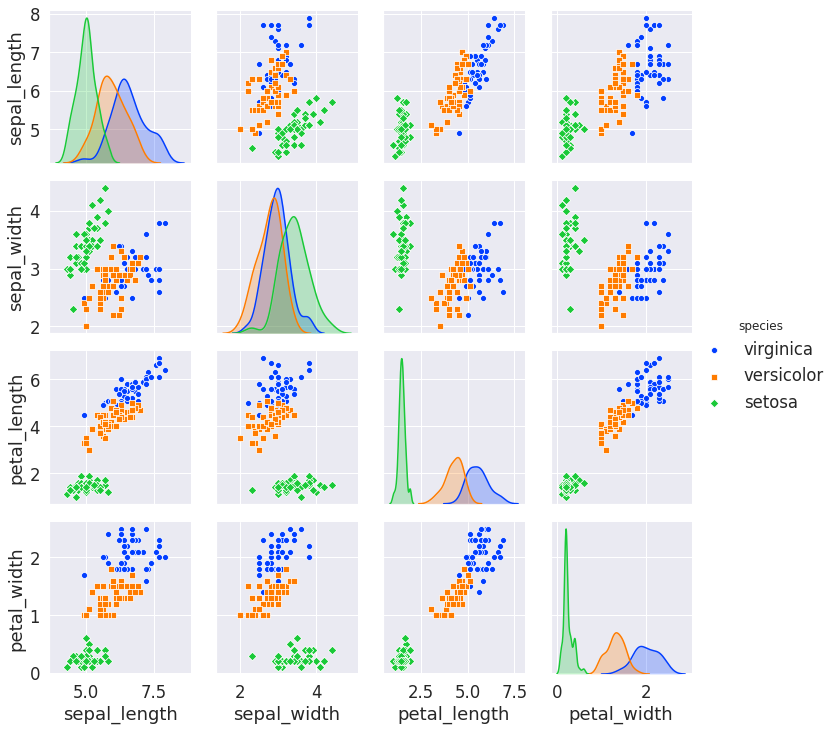

In [70]:
hue_order = df['species'].unique()[::-1]
palette = sns.color_palette('bright')
sns.pairplot(df, hue="species", hue_order=hue_order, palette=palette, markers=["o", "s", "D"], diag_kind='kde');

It seems setosa is an easily separable class in iris in any combination of features. For the he other two classes, we will need special machine learning classifiers. our task here in phase 1 is finding the best classifier model and in phase 2 we compare lda and pca as dimensionality reduction techniques

**Reading data from pandas frame**

In [71]:
columns = list(df.columns)
features = columns[:len(columns)-1]
print("The features are ", features)
f = len(features)
X = df.iloc[:,0:len(columns)-1].values


#Categorical encoding of labels
y,labels = pd.factorize(df['species'])
label_dict = list(labels)

#shapes of arrays
print("input feature matrix", X.shape)
print("labels ",y.shape)
print("number of features", len(features))
print("labels", label_dict)

The features are  ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
input feature matrix (150, 4)
labels  (150,)
number of features 4
labels ['setosa', 'versicolor', 'virginica']


**Using sklearn LDA as classifier**

To visualize the decision region in original data let us consider only two features petal length and petal width in case of iris. k-fold cross validation is a procedure used to estimate the skill of the model on new data.


In [72]:
X_clf = df[['petal_length', 'petal_width']]

scale = StandardScaler()
scale.fit(X_clf)
X_clf_std = scale.transform(X_clf)

In [73]:
def add_labels(standardized=False):
    plt.title('Iris dataset visualized')
    if standardized:
        plt.xlabel('Petal Length (standardized)')
        plt.ylabel('Petal Width (standardized)')
    else:
        plt.xlabel('Petal Length (cm)')
        plt.ylabel('Petal Width (cm)')
    plt.tight_layout()
    plt.show()

**Using Knn as classifier**

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        12
  versicolor       0.80      1.00      0.89        12
   virginica       1.00      0.79      0.88        14

    accuracy                           0.92        38
   macro avg       0.93      0.93      0.92        38
weighted avg       0.94      0.92      0.92        38



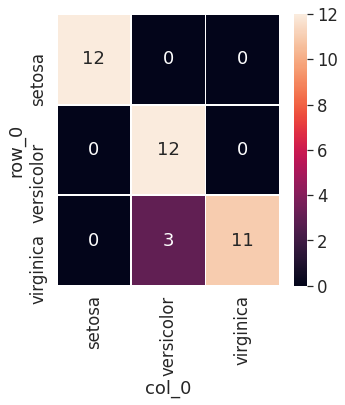

In [74]:
#for different random state (different shuffling), different accuracy will be reported
#so accuracy is high variance estimate

X_clf_train, X_clf_test, y_clf_train, y_clf_test = train_test_split(X_clf, y, 
        test_size=0.25, random_state=6, shuffle=True)

X_clf_train_std, X_clf_test_std, y_clf_train_std, y_clf_test_std = train_test_split(X_clf_std, y, 
        test_size=0.25, random_state=6, shuffle=True)

knn = KNeighborsClassifier(n_neighbors= 5)
knn.fit(X_clf_train_std, y_clf_train_std)
y_pred = knn.predict(X_clf_test_std)
print(classification_report(y_clf_test_std,y_pred,target_names=labels))
cf_matrix = pd.crosstab(labels[y_clf_test_std],labels[y_pred])
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cf_matrix, linewidths=1, annot=True, ax=ax, fmt='g')

In [75]:
from sklearn.model_selection import cross_val_score


#in k fold each data point is used both in training or test in different folds
#for classification problems use stratified sampling , each class in equal proportions in each of the folds


Text(0, 0.5, 'cross validated accuracy(model accuracy)')

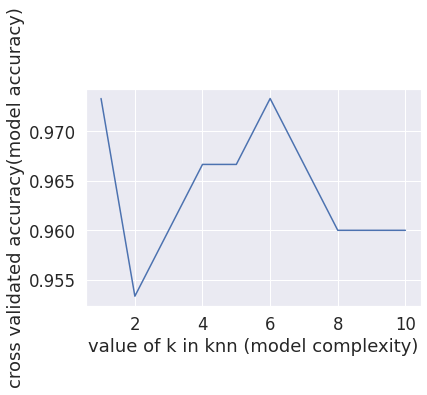

In [76]:
#cross fold validation for hyper parameter tuning, choosing k in knn (this k different from k in k fold)

k_range = range(1, 11)
k_scores = []
for k in k_range:
  knn = KNeighborsClassifier(n_neighbors= k)
  scores = cross_val_score(knn, X_clf_std, y, cv = 10, scoring = 'accuracy')
  k_scores.append(scores.mean())


plt.plot(k_range, k_scores)

plt.xlabel('value of k in knn (model complexity)')
plt.ylabel('cross validated accuracy(model accuracy)')

#u shape is typical bias variance tradeoff curve, 
#low k means low bias, high variance
#high k means high bias, low variance

#best model is found in the middle that balances bias and variance

#in knn hihgher k means lower complexity

0.9733333333333334


/usr/local/lib/python3.6/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())
/usr/local/lib/python3.6/dist-packages/mlxtend/plotting/decision_regions.py:313: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  **scatter_highlight_kwargs)


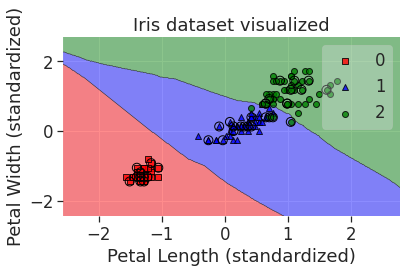

In [77]:
#now k fold cross val to select best model

knn = KNeighborsClassifier(n_neighbors= 6)
print(cross_val_score(knn, X_clf_std, y, cv = 10, scoring = 'accuracy').mean())

# Plot decision regions
knn.fit(X_clf_train_std, y_clf_train_std)
plot_decision_regions(
    X_clf_std, y, X_highlight=X_clf_test_std, clf=knn, colors='red,blue,green'
)
add_labels(standardized=True)



**Using Logistic regression as classifier**

0.96


/usr/local/lib/python3.6/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())
/usr/local/lib/python3.6/dist-packages/mlxtend/plotting/decision_regions.py:313: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  **scatter_highlight_kwargs)


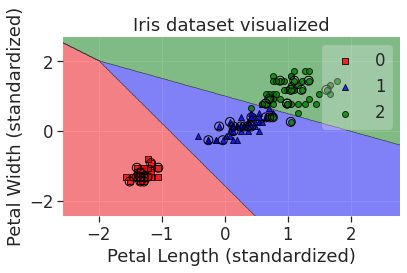

In [78]:
from sklearn.linear_model import LogisticRegression

lgr = LogisticRegression(solver="lbfgs", multi_class="auto")
print(cross_val_score(lgr, X_clf_std, y, cv = 10, scoring = 'accuracy').mean())

# Plot decision regions
lgr.fit(X_clf_train_std, y_clf_train_std)
plot_decision_regions(
    X_clf_std, y, X_highlight=X_clf_test_std, clf=lgr, colors='red,blue,green'
)
add_labels(standardized=True)

0.96


/usr/local/lib/python3.6/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())
/usr/local/lib/python3.6/dist-packages/mlxtend/plotting/decision_regions.py:313: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  **scatter_highlight_kwargs)


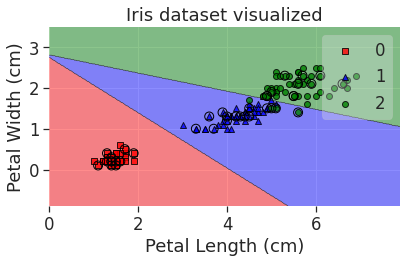

In [79]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
print(cross_val_score(lda, X_clf, y, cv = 10, scoring = 'accuracy').mean())

# Plot decision regions
lda.fit(X_clf_train, y_clf_train)
plot_decision_regions(
    np.asarray(X_clf), y, X_highlight=np.asarray(X_clf_test), clf=lda, colors='red,blue,green'
)
add_labels()

In [80]:
#knn scores high in cross fold

Thus LDA as a classifier has learnt a linear decision boundary from the training set

#**LDA vs PCA as dimensionality reduction technique**

**Class wise mean vectors**

In [81]:
mean_vectors = []
for i in range(3):
    mean_vectors.append(np.mean(X[y==i], axis=0))
    print('Mean Vector class %s: %s\n' %(label_dict[i], mean_vectors[i]))

Mean Vector class setosa: [5.006 3.428 1.462 0.246]

Mean Vector class versicolor: [5.936 2.77  4.26  1.326]

Mean Vector class virginica: [6.588 2.974 5.552 2.026]



**Within class scatter**

In [82]:
S_W = np.zeros((f,f))
n = X.shape[0]

for cl,mv in zip(range(f), mean_vectors):
    class_sc_mat = np.zeros((f,f))                  # scatter matrix for every class
    for row in X[y == cl]:
        row, mv = row.reshape(f,1), mv.reshape(f,1) # make column vectors
        class_sc_mat += (row-mv).dot((row-mv).T)
    S_W += class_sc_mat     # sum class scatter matrices                         
print('within-class Scatter Matrix:\n', S_W)

within-class Scatter Matrix:
 [[38.9562 13.63   24.6246  5.645 ]
 [13.63   16.962   8.1208  4.8084]
 [24.6246  8.1208 27.2226  6.2718]
 [ 5.645   4.8084  6.2718  6.1566]]


**Between class scatter**

In [83]:
overall_mean = np.mean(X, axis=0)

S_B = np.zeros((f,f))
for cl,mean_vec in enumerate(mean_vectors):  
    ncl = X[y==cl,:].shape[0]
    mean_vec = mean_vec.reshape(f,1) # make column vector
    overall_mean = overall_mean.reshape(f,1) # make column vector
    S_B += ncl * (mean_vec - overall_mean).dot((mean_vec - overall_mean).T)

print('between-class Scatter Matrix:\n', S_B)

between-class Scatter Matrix:
 [[ 63.21213333 -19.95266667 165.2484      71.27933333]
 [-19.95266667  11.34493333 -57.2396     -22.93266667]
 [165.2484     -57.2396     437.1028     186.774     ]
 [ 71.27933333 -22.93266667 186.774       80.41333333]]


**Display the eigen vectors and eigen values**

In [84]:
eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

for i in range(len(eig_vals)):
    eigvec_sc = eig_vecs[:,i].reshape(f,1)   
    print('\nEigenvector {}: \n{}'.format(i+1, eigvec_sc))
    print('Eigenvalue {:}: {:.2e}'.format(i+1, eig_vals[i]))


Eigenvector 1: 
[[-0.20874182]
 [-0.38620369]
 [ 0.55401172]
 [ 0.7073504 ]]
Eigenvalue 1: 3.22e+01

Eigenvector 2: 
[[-0.00653196]
 [-0.58661055]
 [ 0.25256154]
 [-0.76945309]]
Eigenvalue 2: 2.85e-01

Eigenvector 3: 
[[-0.87904664]
 [ 0.24960262]
 [ 0.21878648]
 [ 0.34221048]]
Eigenvalue 3: -2.09e-15

Eigenvector 4: 
[[ 0.34924868]
 [-0.42418588]
 [-0.47984978]
 [ 0.68398529]]
Eigenvalue 4: 6.71e-15


**Sorting eigen values to select best discriminant directions**

In [85]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)


print('Eigenvalues in decreasing order:\n')
for i in eig_pairs:
    print(i[0])

Eigenvalues in decreasing order:

32.191929198278025
0.2853910426230689
6.714007081105466e-15
2.09150323208503e-15


**LDA projection matrix**

In [86]:
W = np.hstack((eig_pairs[0][1].reshape(f,1), eig_pairs[1][1].reshape(f,1)))
print('Matrix W:\n', W.real)

Matrix W:
 [[-0.20874182 -0.00653196]
 [-0.38620369 -0.58661055]
 [ 0.55401172  0.25256154]
 [ 0.7073504  -0.76945309]]


In [87]:
X_lda = X.dot(W.real)

**Displaying the plot**

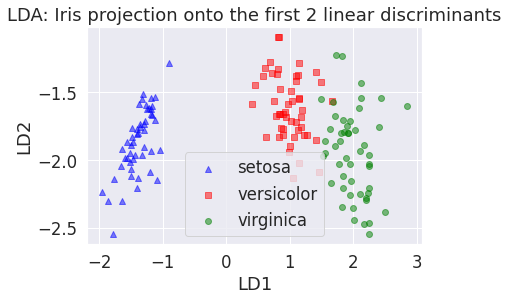

In [88]:
for label,marker,color in zip(range(3),('^', 's', 'o'),('blue', 'red', 'green')):
    plt.scatter(x=X_lda[:,0].real[y == label],
            y=X_lda[:,1].real[y == label],
            marker=marker,
            color=color,
            alpha=0.5,
            label=label_dict[label]
            )

plt.xlabel('LD1')
plt.ylabel('LD2')

leg = plt.legend(loc='best', shadow=False, fancybox=True)
plt.title('LDA: Iris projection onto the first 2 linear discriminants')

plt.tight_layout
plt.show()



**PCA of dataset**

In [89]:
pca = PCA(n_components=2)
X = StandardScaler().fit_transform(X)
X_pca = pca.fit(X).transform(X)

**Variance of dataset in the principal components**

In [90]:
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

explained variance ratio (first two components): [0.72962445 0.22850762]


**Displaying plot**

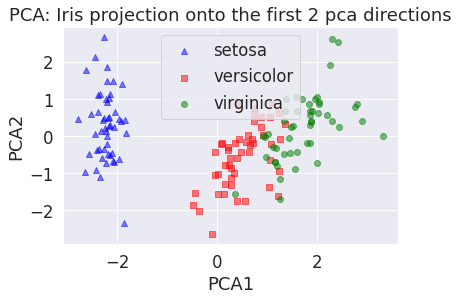

In [91]:
for label,marker,color in zip(range(3),('^', 's', 'o'),('blue', 'red', 'green')):
    plt.scatter(x=X_pca[:,0].real[y == label],
            y=X_pca[:,1].real[y == label],
            marker=marker,
            color=color,
            alpha=0.5,
            label=label_dict[label]
            )

plt.xlabel('PCA1')
plt.ylabel('PCA2')

leg = plt.legend(loc='best', shadow=False, fancybox=True)
plt.title('PCA: Iris projection onto the first 2 pca directions')

plt.tight_layout
plt.show()

Versicolor and Virginica are separated much better in LDA than in PCA

**Effect of standardization on LDA**

In [92]:
#@title
dfscaled = df

col = df.columns.delete(-1)
dfscaled[col] = StandardScaler().fit_transform(dfscaled[col])
X_std = dfscaled.iloc[:,0:len(columns)-1].values


mean_vectors = []
for i in range(3):
    mean_vectors.append(np.mean(X_std[y==i], axis=0))

S_W = np.zeros((f,f))
n = X_std.shape[0]
for cl,mv in zip(range(f), mean_vectors):
    class_sc_mat = np.zeros((f,f))                  
    for row in X_std[y == cl]:
        row, mv = row.reshape(f,1), mv.reshape(f,1) 
        class_sc_mat += (row-mv).dot((row-mv).T)
    S_W += class_sc_mat 

overall_mean = np.mean(X_std, axis=0)
S_B = np.zeros((f,f))
for cl,mean_vec in enumerate(mean_vectors):  
    ncl = X_std[y==cl,:].shape[0]
    mean_vec = mean_vec.reshape(f,1) 
    overall_mean = overall_mean.reshape(f,1) 
    S_B += ncl * (mean_vec - overall_mean).dot((mean_vec - overall_mean).T)


eig_vals_s, eig_vecs_s = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))
eig_pairs_s = [(np.abs(eig_vals_s[i]), eig_vecs_s[:,i]) for i in range(len(eig_vals_s))]
eig_pairs_s = sorted(eig_pairs_s, key=lambda k: k[0], reverse=True)

**LDA is not affected by standardization**

Eigen values of unstandardized data
32.191929198278025
0.2853910426230689
6.714007081105466e-15
2.09150323208503e-15
Eigen values of standardized data
32.191929198278025
0.2853910426230685
5.470673123572336e-15
4.0664699298164e-15


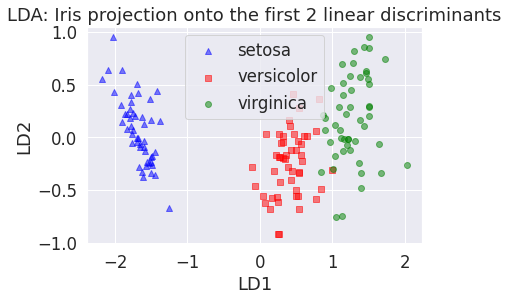

In [93]:
print("Eigen values of unstandardized data")
for i in eig_pairs:
    print(i[0])
print("Eigen values of standardized data")
for i in eig_pairs_s:
    print(i[0])

W = np.hstack((eig_pairs_s[0][1].reshape(f,1), eig_pairs_s[1][1].reshape(f,1)))
X_lda = X.dot(W)

for label,marker,color in zip(range(3),('^', 's', 'o'),('blue', 'red', 'green')):
    plt.scatter(x=X_lda[:,0].real[y == label],
            y=X_lda[:,1].real[y == label],
            marker=marker,
            color=color,
            alpha=0.5,
            label=label_dict[label]
            )

plt.xlabel('LD1')
plt.ylabel('LD2')

leg = plt.legend(loc='best', shadow=False, fancybox=True)
plt.title('LDA: Iris projection onto the first 2 linear discriminants')

plt.tight_layout
plt.show()

The eigen values of unstandardized and standardized data are almost same, the last two eigen values vary because of precision. Only the scaling of the component axes have changed but the projection is the same

In [94]:
#cross val ref : https://www.youtube.com/watch?v=6dbrR-WymjI